# Generating relative value trade ideas using PCA

The goal of this exercise is to implement a framework for identifying and analyzing relative value trades using PCA and Python. 

## Setting it up

Let's first import the dependencies we will need. 

In [1]:
%matplotlib inline

import quandl

import numpy as np
from numpy import array
import pandas as pd
from operator import sub
import pickle
import math
import itertools as iter
import datetime as dt
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA

from IPython.display import display, HTML


mat = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
mat = [str(i)+"y" for i in mat]
bpv = [100.86, 201.84, 301.07, 399.71, 496.76, 592.32, 686, 
       778.72, 869.16, 957.75, 1372.68, 1742.77, 2072.96, 2368.97]

pv01s = {k:v for k, v in zip(mat, bpv)}
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

print ("Loaded!")

cwd = os.getcwd()


Loaded!


We will be performing our exercise on the German yield curve from Quandl. Free data is available from January 2010 to December 2014.

,2Y,5Y,7Y,10Y
Date,,,,
2011-09-05,42.8,94.7,134.6,184.7
2011-09-12,43.4,88.1,126.4,174.3
2011-09-19,46.4,96.0,134.7,180.0
2011-09-26,45.1,98.0,136.4,182.9
2011-10-03,49.5,110.2,135.8,181.5


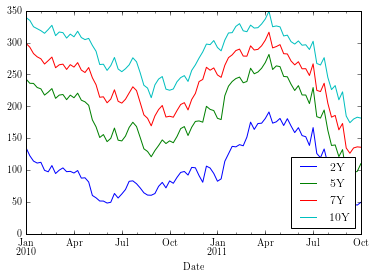

In [2]:

country = "GER"
"""
rawData = quandl.get("YC/"+country, authtoken="hHmwzKyDyqaHhJLF1eFe")


#get data from pickle 
#rawData = pd.read_pickle("%s/depo/rawData"%cwd)[dt.datetime(2007,1,1):]
#rawData = rawData.astype(float)

#Let's focus on 2y, 5y, 7y, 10y, 20y and 30y
assets = ['2-Year', '5-Year', '7-Year', '10-Year']
#assets = ['2 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']
rawData = rawData[assets]

#convert to bps
rawData *= 100
"""
rawData = pd.read_csv("bookData.csv", sep=",")

rawData["Date"] = pd.to_datetime(rawData["Date"], infer_datetime_format=True)
rawData.set_index("Date", drop=True, inplace=True)

assets = rawData.columns.values
start = dt.datetime(2010, 1, 4)
end = dt.datetime(2011, 10, 3)

#start = dt.datetime(2012, 6, 1)
#end = dt.datetime(2016, 6, 1)

rawData.loc[:] *= 100 
data = rawData[start:end]


display(data.tail())
data.plot()


## change dates

## Writing the static PCA function

We'll try to write a function staticPCA. It takes in our raw data, number of components we are interested in (default 4) and resample frequency on the raw data (default 1). It also takes in corrW (default 20), which is used to determine how many periods to use in the rolling correlation of reconstructed factors.

The output of the function will be a dictionary of resultant eigenvalues, eigenvectors, the covariance matrix, and historical reconstructed factors.

Further down the line, we will also need k-factor residuals (residuals found by reconstructing the data using only k-1 factors). We write this helper function and use it in the staticPCA function now, to make things a bit easier.

In [3]:
def kfacReconstruct(data, evTable, k=3, cols = []):
    
    ## Pick securities to receive data for. If no input, do all. 
    if cols ==[]: 
        cols = data.columns.values
    
    # Returns k-factor reconstruction when given the data and Eigenvectors
    
    result = {}
    
    totFactors = len(evTable.columns.values)
    if totFactors < k:
        print ("Error! Total factors are less than k.")
        return
    
    # get demeaned data
    meanVals = data.mean()
    demeaned = data - meanVals
    
    #reconstruct historical factor time series
    factorTS = demeaned.dot(evTable)

    
    #inverse of eigenvectors
    invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)

    #drop columns to adjust for k factors
    factorTS.drop(factorTS.columns[range(len(factorTS.columns.values))[k:]], axis=1, inplace=True)
    
    #drop rows to adjust for k factors
    invEV.drop(invEV.index[range(len(invEV.index.values))[k:]], axis=0, inplace=True)
    
    #### Reconstruction using k factors
    kRebuild = factorTS.dot(invEV)
    kResiduals = demeaned - kRebuild
    reRaw = kRebuild + meanVals
    
    result["factorTS"] = factorTS
    result["rebuildRaw"] = reRaw[cols]
    result["residuals"] = kResiduals[cols]
    
    return result
    

def staticPCA(data, n=3, freq=1, corrW = 12):
    '''
    This function returns a dictionary with the following key value combinations:
    key    | Value
    raw    | DF with raw data (as resampled)
    covM   | Covariance matrix of raw data
    evals  | n eigenvalues
    evecs  | n eigenvectors
    facTS  | time series of reconstructed factors using raw data. 
    reRaw  | Rebuilt raw data from n EVs, and accompanying residuals
    resid  | Residuals (Actual - Reconstructed)
    facCR  | Rolling cross correlations between factors
    '''
    results = {}
    
    ## resample data based on freq and calc demeaned data
    raw = data.iloc[::freq, :]
    results["rawDat"] = raw
    meanVals = raw.mean()
    demeaned = raw - meanVals
    
    ## Covariance Matrix
    covM = raw.cov()
    results["covM"] = covM

    ## PCA
    evals, evecs = np.linalg.eig(covM)
    epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
    epairs.sort(key=lambda x: x[0], reverse=True)
    evals = sorted([i*100/sum(evals) for i in evals])[::-1][:n]
    results["evals"] = evals

    evTable = pd.DataFrame(index=covM.index)
    for i in range(n):
        if i==1:
            evTable.insert(i, "PC"+str(i+1), -epairs[i][1])
        else:
            evTable.insert(i, "PC"+str(i+1), epairs[i][1])
    results["evecs"] = evTable

    ## Reconstruct
    reconstructed = kfacReconstruct(raw, evTable, n)
    resid = reconstructed["residuals"]
    facTS = reconstructed["factorTS"]
    reRaw = reconstructed["rebuildRaw"]
    
    results["resid"] = resid
    results["facTS"] = facTS
    results["reRaw"] = reRaw
    

    ## Rolling correlations of factors
    facCR = pd.DataFrame()
    combos =[facTS[list(pair)] for pair in list(iter.combinations(facTS.columns, 2))]
    for df in combos:
        cols = df.columns.values
        facCR["".join(cols)] = facTS[cols[0]].rolling(window=corrW).corr(other=facTS[cols[1]])

    results["facCR"] = facCR
    return results




## Playing around with the function results

Let's load our German Yield curve data into this function and see what we get.

Eigenvectors:


,PC1,PC2,PC3
2Y,0.421718,-0.835988,0.308821
5Y,0.554351,-0.044949,-0.825156
7Y,0.530166,0.287945,0.421667
10Y,0.483500,0.464964,0.214347


Eigenvalues:


[92.510426610001957, 7.1917777461596257, 0.25374786518727299]

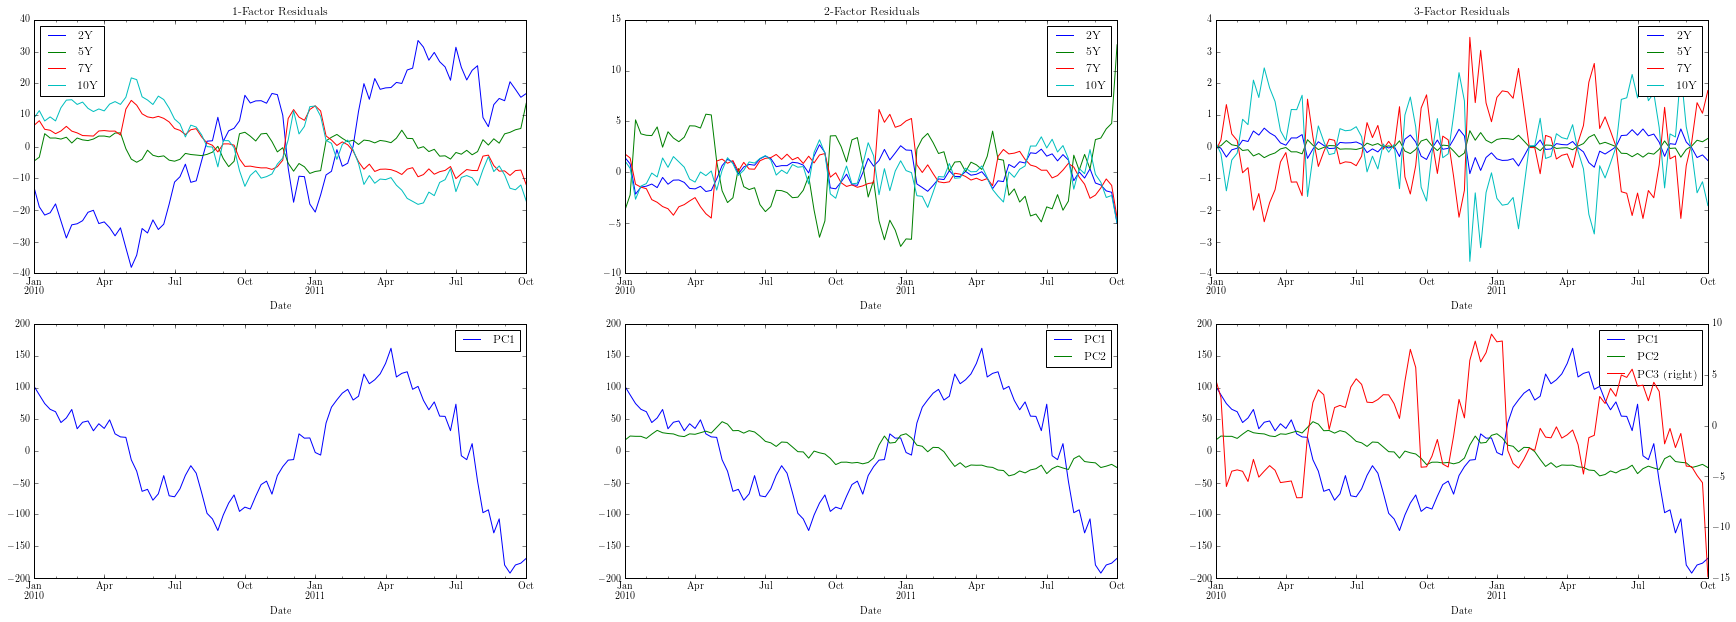

In [4]:
print("Eigenvectors:")
pca1 = staticPCA(data, freq=1, n=1)
pca2 = staticPCA(data, freq=1, n=2)
pca3 = staticPCA(data, freq=1, n=3)
display(pca3["evecs"])
print("Eigenvalues:")
display(pca3["evals"])


fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pca1["resid"].plot(ax=axes[0, 0], title="1-Factor Residuals")
pca1["facTS"].plot(ax=axes[1, 0])

pca2["resid"].plot(ax=axes[0, 1], title="2-Factor Residuals")
pca2["facTS"].plot(ax=axes[1, 1])

pca3["resid"].plot(ax=axes[0, 2], title="3-Factor Residuals")
pca3["facTS"].plot(ax=axes[1, 2], secondary_y="PC3")



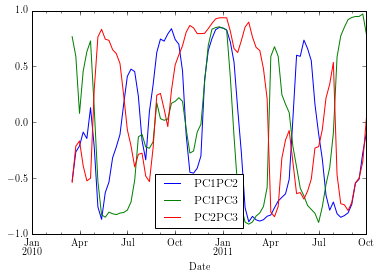

In [5]:
pca3["facCR"].plot()

# Residuals

We create a one page summary of the residuals, which might potentially highlight attractive trades.


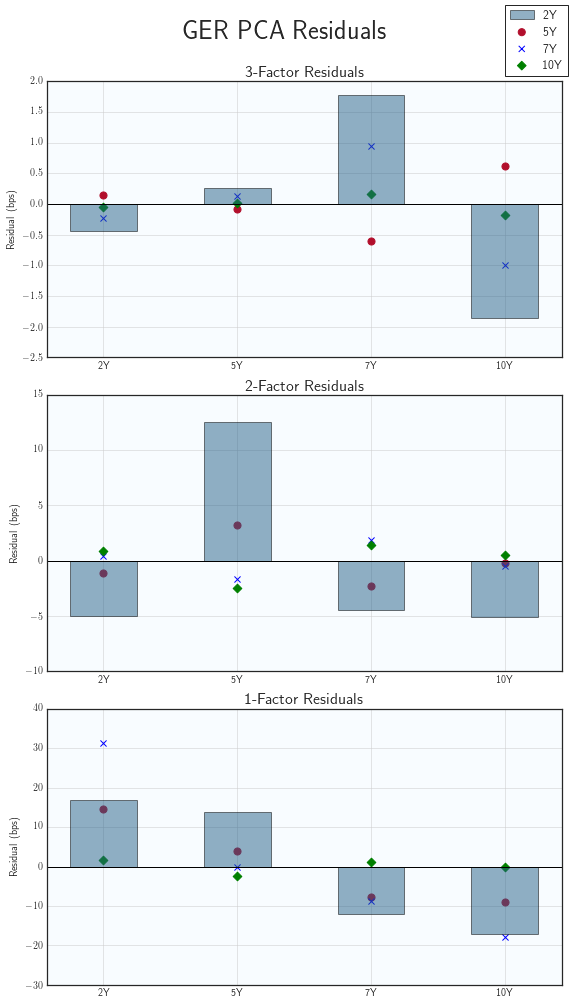

In [6]:
########### Residuals ############
## LEVEL
xvals = range(len(assets))

relVal1 = pd.DataFrame()
relVal1 = pca1["resid"].ix[[-1, -5, -20, -60]]
relVal1.index = ["1d", "1w", "1m", "3m"]
relVal1 = relVal1.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 14), dpi=400)
fig.suptitle("%s PCA Residuals"%country, fontsize=26)

### 1-Factor PCA residual 
ax1 = plt.subplot2grid((3, 1), (2, 0), colspan=1)
xvals = range(len(assets))
lday=ax1.bar(xvals, relVal1["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax1.set_xticks(xvals)
ax1.set_xticklabels(assets)
plt.grid()
s = 25
lwk= ax1.scatter(xvals, relVal1["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
lmnth=ax1.scatter(xvals, relVal1["1m"], color='b', marker = "x", s=1.5*s, label="1m")
lquart=ax1.scatter(xvals, relVal1["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax1.axhline(0, color="black")
ax1.set_title("1-Factor Residuals", fontsize="16")
ax1.set_axis_bgcolor('#f8fcff')
ax1.set_ylabel("Residual (bps)")

## 2-Factor PCA residual

relVal2 = pd.DataFrame()
relVal2 = pca2["resid"].ix[[-1, -5, -20, -60]]
relVal2.index = ["1d", "1w", "1m", "3m"]
relVal2 = relVal2.transpose()

ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1)
ax2.bar(xvals, relVal2["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax2.set_xticks(xvals)
ax2.set_xticklabels(assets)
plt.grid()
s = 25
ax2.scatter(xvals, relVal2["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax2.scatter(xvals, relVal2["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax2.scatter(xvals, relVal2["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax2.axhline(0, color="black")
ax2.set_title("2-Factor Residuals", fontsize="16")
ax2.set_axis_bgcolor('#f8fcff')
ax2.set_ylabel("Residual (bps)")

## 3-Factor PCA residual


relVal3 = pd.DataFrame()
relVal3 = pca3["resid"].ix[[-1, -5, -20, -60]]
relVal3.index = ["1d", "1w", "1m", "3m"]
relVal3 = relVal3.transpose()

ax3 = plt.subplot2grid((3, 1), (0, 0), colspan=1)
ax3.bar(xvals, relVal3["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax3.set_xticks(xvals)
ax3.set_xticklabels(assets)
plt.grid()
s = 25
ax3.scatter(xvals, relVal3["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax3.scatter(xvals, relVal3["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax3.scatter(xvals, relVal3["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax3.axhline(0, color="black")
ax3.set_title("3-Factor Residuals", fontsize="16")
ax3.set_axis_bgcolor('#f8fcff')
ax3.set_ylabel("Residual (bps)")


fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.figlegend([lday, lwk, lmnth, lquart], relVal1.index.values, frameon=True,loc="upper right" )
plt.savefig("%s/depo/PCA Residuals - %s"%(cwd,(data.index[-1].strftime("%d %b %y"))))


At the end of the exercise, we will dive quite a bit deeper into the results. For now, let's go back implement a rolling PCA using our staticPCA function.

# Rolling PCA

Here we try to implement a rolling PCA in order to study the stability of eigenvectors and eigenvalues over time.


In [7]:
def rollingPCA(data, lb=30, n=3, corrW=12, skip=1):
    """
    For now, this function returns a data frame with time series of eigenvalues and eigenvectors of a rolling PCA. 
    """

    rollResult = {}
    
    assets = data.columns.values
    pcCols = ["PC"+str(i+1) for i in range(n)]
    eVecCols = [pc+asset for pc in pcCols for asset in assets]
    
    # Create dataframe for results. 
    accumEvals = pd.DataFrame(columns = range(1, n+1), index=data.index.values[lb:])
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=assets, index=data.index.values[lb:]))
    alleVectors = pd.DataFrame(index=data.index.values[lb:], columns = eVecCols)
    
    ### Rolling PCA - Loop and save data.
    
    for i in range(0, len(data.index)-lb, skip):
        
        temp = data[i:lb+i]
        currDate = data.index.values[lb+i]
        res = staticPCA(temp, n=n, corrW=corrW)

        ## Save eigenvalues
        eigenvalues = res["evals"]
        for j in range(len(eigenvalues)):
            accumEvals.set_value(currDate,j+1,eigenvalues[j])

        ## Save eigenvectors
        eigenvectors = res["evecs"]
        tempDict = {}
        for pc in pcCols:
            factor = eigenvectors[pc]
            #print (i, pc, factor.tolist())
            for k in range(len(assets)):
                alleVectors.set_value(currDate, pc+assets[k], factor[k])
    
    #### Split data into PC1, PC2, PC3 and drop NAs.
    
    accumEvals = accumEvals.dropna()

    grouped = alleVectors.groupby(lambda x: x[:3], axis=1)
    
    for pc in pcCols:
        accumEvecs[pc] = grouped.get_group(pc).dropna()
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    accumEvals.columns = pcCols
    rollResult["evectors"] = accumEvecs
    rollResult["evalues"] = accumEvals
    
    ## Secret
    rollResult["master"] = alleVectors.dropna()
    
    return rollResult
            
pcaResults = rollingPCA(data)
print ("Done!")


Done!


Let's see what the eigenvalues and eigenvectors look like over time. Their stability would highlight the effectiveness of the PCA based model for this particular set of data.

Eigenvalues:


,PC1,PC2,PC3
2011-09-05,97.8908,1.99433,0.0938771
2011-09-12,98.6993,1.19914,0.0851609
2011-09-19,99.2214,0.685638,0.0796252
2011-09-26,99.4946,0.41485,0.0792561
2011-10-03,99.5891,0.323753,0.0769784


####### PC1 historical ########
                  2Y        5Y        7Y       10Y
2011-09-05  0.438736  0.560715   0.52585  0.465393
2011-09-12  0.444037  0.555402  0.526372  0.466147
2011-09-19  0.444543  0.551767  0.527362  0.468854
2011-09-26  0.446305  0.548858    0.5271  0.470885
2011-10-03  0.448604  0.546656  0.526953  0.471426
####### PC2 historical ########
                  2Y        5Y        7Y       10Y
2011-09-05 -0.867975  0.102595  0.241767  0.421476
2011-09-12 -0.865008    0.1109  0.230338  0.431748
2011-09-19 -0.866512  0.122385  0.218507   0.43178
2011-09-26  -0.86523  0.131111  0.204097  0.438783
2011-10-03 -0.868636  0.148763  0.203629  0.426469
####### PC3 historical ########
                  2Y        5Y         7Y       10Y
2011-09-05  0.230272 -0.734706  0.0270569  0.637534
2011-09-12  0.225091 -0.758916  0.0737028  0.606588
2011-09-19  0.213259 -0.765317  0.0865553  0.601098
2011-09-26 -0.210025  0.762068 -0.0723578   -0.6082
2011-10-03 -0.189744  0.761685 -

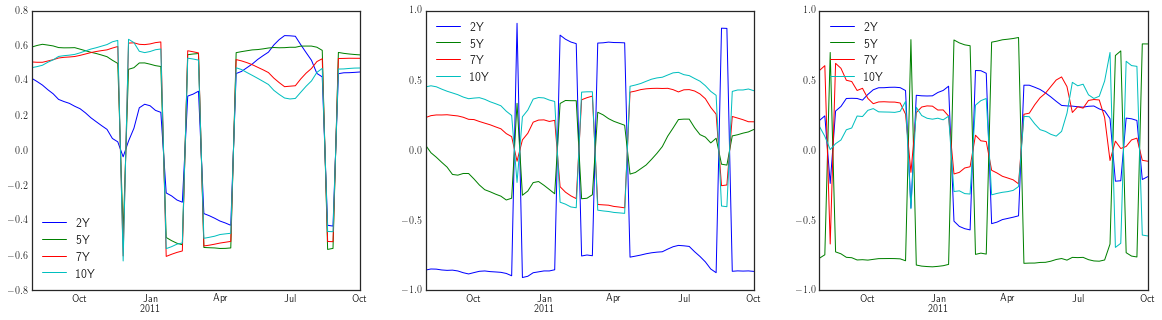

In [8]:

print ("Eigenvalues:")
display(pcaResults["evalues"].tail())
print ("####### PC1 historical ########")
print (pcaResults["evectors"]["PC1"].tail())
print ("####### PC2 historical ########")
print (pcaResults["evectors"]["PC2"].tail())
print ("####### PC3 historical ########")
print (pcaResults["evectors"]["PC3"].tail())

pc1raw = pcaResults["evectors"]["PC1"]
pc2raw = pcaResults["evectors"]["PC2"]
pc3raw = pcaResults["evectors"]["PC3"]

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

pc1raw.plot(ax=axes[0])
pc2raw.plot(ax=axes[1])
pc3raw.plot(ax=axes[2])


Wait, what? 

Ok, so this is because the static PCAs that are being run sometimes will generate eigenvectors that are in the opposite orientation of the previous eigenvector. But this isn't really a point to worry about. Eigenvectors would be equivalent to their negatives. What we can do, however, is to try our best to flip the eigenvectors to the direction that makes sense. 

The following function tries to achieve this task. It is not perfect, but it does not affect the purposes of the exercise (which is to determine the stability of the EVs). The stability is discernible well enough with the smoothing applied.

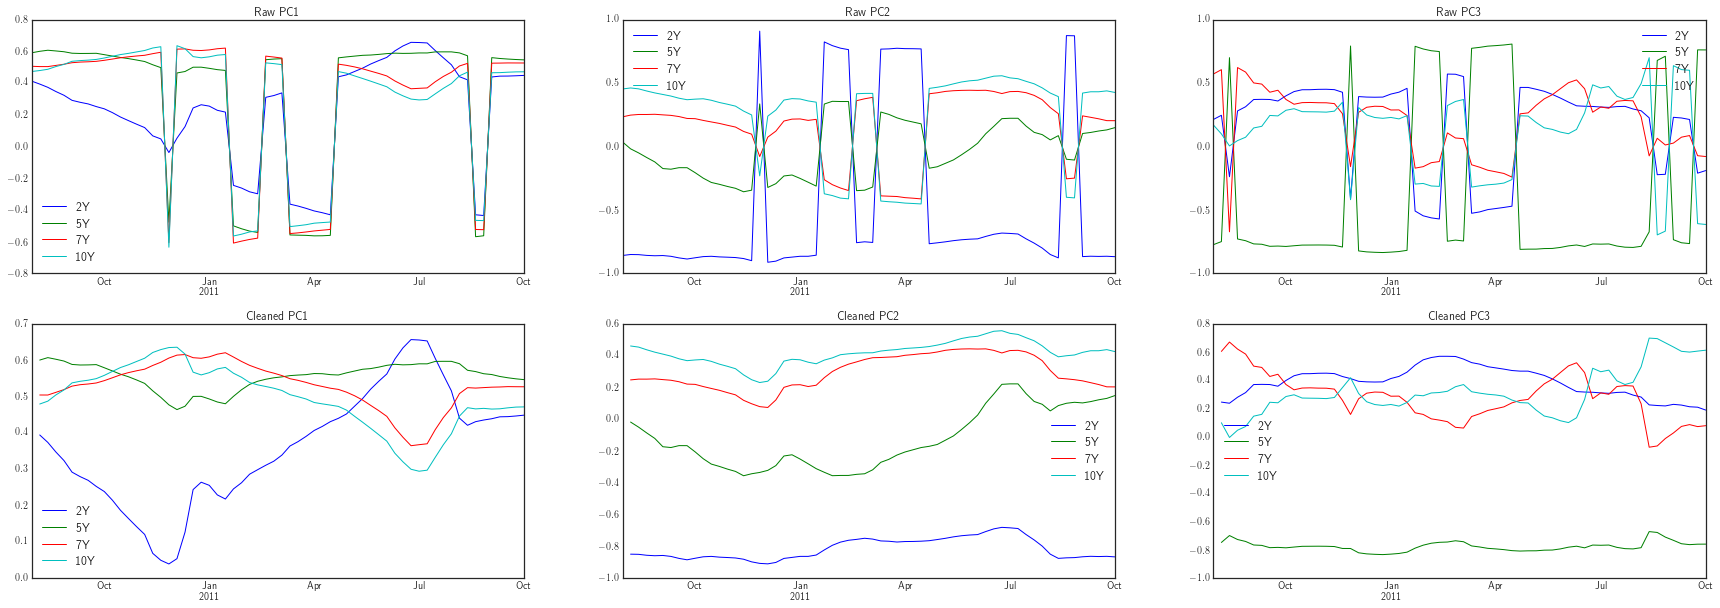

In [9]:

def cleanPCs(input, smoothing=0):
    newdf = pd.DataFrame(index=input.index.values, columns=input.columns.values)
    flag = "flipped"

    for i in range(1, len(input)):
        if i ==1:
            prevfactor = input.iloc[i-1]
        else:
            prevfactor = newdf.iloc[i-1]
        factor = input.iloc[i]
        negfactor = [-i for i in factor.tolist()]

        orig = sum([np.abs(x) for x in (factor-prevfactor).tolist()])
        new = sum([np.abs(x) for x in (-factor-prevfactor).tolist()])
        
        if orig > new:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], -1*input.iloc[i, s])
                flag = "flipped"
        else:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], input.iloc[i, s])
                flag = "same"
    
    if smoothing==1:
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]

        
    return newdf
            

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pc1raw.plot(ax=axes[0, 0], title="Raw PC1")
cleanPCs(pc1raw).plot(ax=axes[1, 0], title="Cleaned PC1")

pc2raw.plot(ax=axes[0, 1], title="Raw PC2")
cleanPCs(pc2raw).plot(ax=axes[1, 1], title="Cleaned PC2")

pc3raw.plot(ax=axes[0, 2], title="Raw PC3")
cleanPCs(pc3raw).plot(ax=axes[1, 2], title="Cleaned PC3")

Ah, much better. As we can see, the PCs are generally quite stable, with stability increasing with order. 

What about the Eigenvalues?

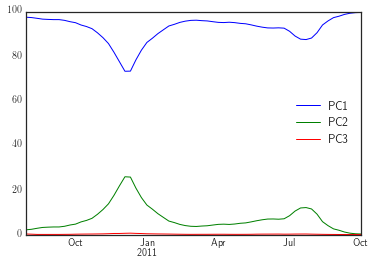

In [10]:
pcaResults["evalues"].plot()

Not too bad. 

# Snapshots over time

This function will generate a subset of the rolling PCA results, showing only snapshots on an input set of dates and a lookback period on the rolling PCA.

In [11]:
lb = 30
testDates = [data.index.values[i] for i in range(lb, len(data.index.values)-lb, 10)]
target = pd.DataFrame(index=testDates)

orig = pcaResults["master"]

result = target.join(orig)
#print (result)

def pcaSnapshot(dates, data, lb=30, n=3,orient=True, vec=[], tol=1.5):
    # Returns tuple of evalues and a dict of evectors.
    reorient = len(dates)*[1]
    
    pcaResults = rollingPCA(data, lb=lb, n=n)
    orig = pcaResults["master"]
    evectors = pd.DataFrame(index=dates).join(orig)
    
    evalues = pd.DataFrame(index=dates).join(pcaResults["evalues"])

    pcCols = evalues.columns.values
    
    grouped = evectors.groupby(lambda x: x[:3], axis=1)
    
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=data.columns.values, index=data.index.values[lb:]))
    flag = 0
    for pc in pcCols:
        
        if flag == 0 and orient :
            flag = 1
            temp = grouped.get_group(pc).dropna()
            temp['orient'] = temp.applymap(np.sign).sum(axis=1)
            reorient = temp["orient"].apply(lambda x: (-1)**((np.abs(x-temp["orient"].mean())/temp["orient"].std()<tol)-1))
        
        factors = grouped.get_group(pc).dropna()
            
        accumEvecs[pc] = factors.mul(reorient, axis=0)
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    
    return evalues, accumEvecs

testSnap = pcaSnapshot(testDates, data, orient=True, tol=1.5)

print ("Done")

Done


Let's display the results.

,PC1,PC2,PC3
2010-08-02,97.4399,2.18915,0.321168
2010-10-11,93.9532,5.73727,0.265854
2010-12-20,78.3262,20.8818,0.587982
2011-02-28,96.022,3.77288,0.156613


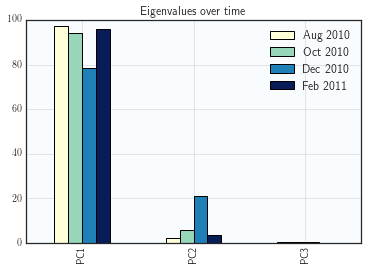

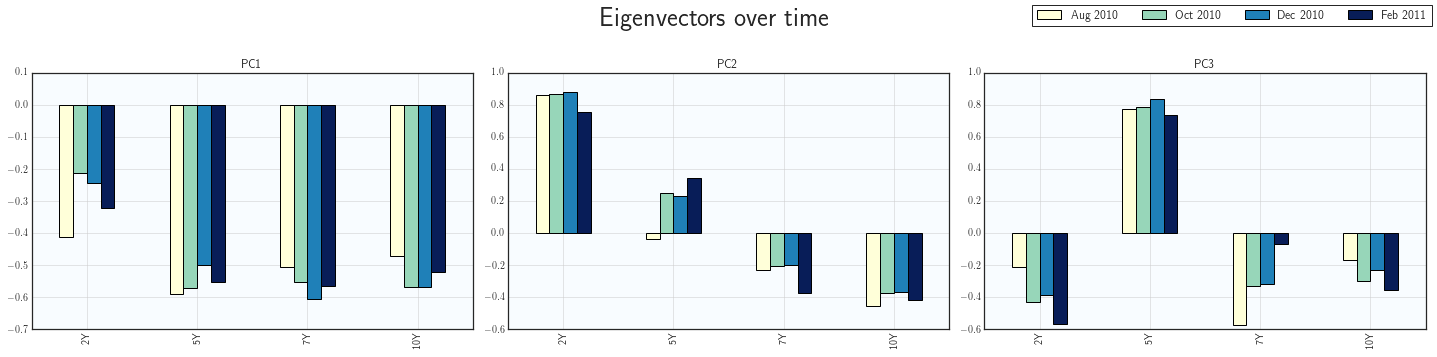

In [12]:
evalues = testSnap[0]
evectors = testSnap[1]

## Eigenvalues
display(evalues)
dateStrings = [pd.to_datetime(str(date)).strftime("%b %Y") for date in evalues.index.values]
ax = evalues.transpose().plot(kind="bar", title="Eigenvalues over time", colormap="YlGnBu", grid=True)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, dateStrings, loc="best")
ax.set_axis_bgcolor("#f8fcff")

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)


for i in range(len(evectors.keys())):
    ax = evectors["PC"+str(i+1)].transpose().plot(ax=axes[i], kind="bar", legend=False, colormap="YlGnBu", grid=True)
    lines, labels = ax.get_legend_handles_labels()
    ax.set_axis_bgcolor('#f8fcff')
    ax.set_title("PC"+str(i+1))
    #ax.legend(lines, dateStrings, loc="best")

fig.suptitle("Eigenvectors over time", fontsize="26")
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.figlegend(lines, dateStrings, frameon=True,loc="upper right", ncol=len(dateStrings))




# Generating weights for curve and fly trades

The next thing to do is create a function that would generated trades that are PC hedged. 

In [13]:
curve = "2s10s"
fly = "2s5s7s"
import string


def returnNotWgts(trade, evectors, bpvs=0):
    ### Returns notionals to use in trades
    tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
    tenors = [str(i)+"y" for i in tenors]
    ## re-index evectors:
    newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in evectors.index.values]
    evectors.index = newIndex
    
    if bpvs == 0:
        return returnRiskWgts(trade, evectors)
    
    ## curves
    if len(tenors)==2:
        ## longer tenor = 1
        short = tenors[0]
        long = tenors[1]
        es = evectors.at[short, "PC1"]
        el = evectors.at[long, "PC1"]
        return [-bpvs[long]/bpvs[short]*el/es, 1]
    
    if len(tenors)==3:
        ## get belly and wings. Assume belly = 1.
        belly = tenors[1]
        wings = [w for w in tenors if w not in belly]
        ## get eigenvector subset
        
        #LHS
        wingFactors = pd.DataFrame(index=wings)
        wingFactors = wingFactors.join(evectors).ix[:,:-1].transpose()
        wingRisk = np.diag([bpvs[x] for x in wings])
        coeff = wingFactors.dot(wingRisk)
        invcoeff = np.linalg.pinv(coeff)
        
        #RHS
        bellyFactor = pd.DataFrame(index=[belly])
        bellyFactor = bellyFactor.join(evectors).ix[:,:-1].transpose()
            
        bellyFactor.loc[:] *= -bpvs[belly]
                
        wingWeights = list(np.ravel(invcoeff.dot(bellyFactor)))
        wingWeights.insert(1, 1)
        
        
        return wingWeights
    else:
        print("Oops. Not enough, or too many instruments.")
        
        
    return

def returnRiskWgts(trade, evectors):
    ### Returns notionals to use in trades
    tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
    tenors = [str(i)+"y" for i in tenors]
    ## re-index evectors:
    newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in evectors.index.values]
    evectors.index = newIndex

    if len(tenors)==2:
        short = tenors[0]
        long = tenors[1]
        es = evectors.at[short, "PC1"]
        el = evectors.at[long, "PC1"]
        return [-el/es, 1]
    
    if len(tenors)==3:
        belly = tenors[1]
        wings = [w for w in tenors if w not in belly]
        
        wingFactors = pd.DataFrame(index=wings)
        wingFactors = wingFactors.join(evectors).ix[:,:-1].transpose()
        bellyFactor = pd.DataFrame(index=[belly])
        bellyFactor = bellyFactor.join(evectors).ix[:,:-1].transpose()
        
        invcoeff = np.linalg.pinv(wingFactors)
        bellyFactor.loc[:] *= -1
        rhs = invcoeff.dot(bellyFactor)
        rhs = list(np.ravel(rhs))
        rhs.insert(1, 1)
        
        return rhs
    else:
        print("Oops. Not enough, or too many instruments.")
    return

        
def bpvWgts(trade, bpvs):
    tenors 

Testing it here:

In [14]:
print (returnNotWgts(curve, pca3["evecs"], pv01s))
print (returnRiskWgts(fly, pca3["evecs"]))
print (returnNotWgts(fly, pca3["evecs"],pv01s))


[-5.4402558015426363, 1]
[-0.3249008198491643, 1, -0.78717694115528825]
[-0.79963204155901169, 1, -0.57002626426866065]


We are going to need a function to generate the time series for weighted flies. 

In [25]:
def deMean(df):
    return (df - df.mean())


def genTrades(data, trade, pca=True):
    ## Re-label tenor buckets, check for errors. 
    tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
    tenors = [str(i)+"y" for i in tenors]
    dataCheck = [''.join(i for i in x if i.isdigit())+"y" for x in data.columns.values]
    if not set(tenors).issubset(set(dataCheck)):
        print("Data error.")
        return 
    
    tradeData = data[]
    tradeData = 
    tradeData.columns = dataCheck
    
    print (tradeData.head())
    
    return


"""
def genTrades(data, trade, pca=True,fac=3, f=1):
    
    Returns trade time series, and residuals for curves and flies that are input. 
    
    Performs a n-factor PCA on the data with freq of f.

    ## If not enough values to perform PCA, exit.
    if lb > len(data.index.values):
        print("Not enough data for PCA. Exiting...")
        return
    final = {}

    
    ## Relabel tenors for ease of use. 
    tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
    tenors = [str(i)+"y" for i in tenors]
    
    ## If an asset from a trade doesn't exist in the input dataframe, exit.
    dataCheck = [''.join(i for i in x if i.isdigit())+"y" for x in data.columns.values]
    if not set(tenors).issubset(set(dataCheck)):
        print("Data error.")
        return  
    
    tradeData = data
    tradeData.columns = dataCheck
    
    #### Perform n-factor PCA over past lb lookback periods with freq of f.
    pca = staticPCA(tradeData, n=fac, freq=f)
    eigenvectors = pca["evecs"]
    print (eigenvectors)
    newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in eigenvectors.index.values]
    eigenvectors.index = newIndex
    
    ## Get residual data reconstruction for each factor
    kfacResid=dict.fromkeys(range(1, fac+1))
    for j in range(1,fac+1):
        kfacResid[j] = kfacReconstruct(tradeData, eigenvectors, j, cols=tenors)
    #print (kfacResid[2])
    
    tsCols = tenors + ["PV01 - "+trade, "PCA -"+trade, "121 - "+trade]
    tradeData = data[tenors].copy()
    #print (tradeData.tail())
    
    ## Save factors
    final["factors"] = kfacResid[3]["factorTS"]

    ### Curve Trades
    if len(tenors) == 2:
        if len(eigenvectors.columns.values) < 2 or not set(tenors).issubset(newIndex):
            print ("Eigenvector or PV01 error.")
            return
        
        ### Save trades and weighted trades, and residuals 
        wgts = returnRiskWgts(trade, eigenvectors)
        
        tradeData.loc[:,"PV01 - "+trade] = tradeData.apply(lambda x: x[tenors[1]] - x[tenors[0]], axis = 1)
        tradeData.loc[:,"PCA - "+trade] = tradeData.apply(lambda x: x[tenors[1]]*wgts[1] + x[tenors[0]]*wgts[0], axis=1)
        final["ts"] = tradeData
        pltTS = tradeData.loc[:,["PV01 - "+trade, "PCA - "+trade]].copy()
        pltTS.plot(title="curve price plot", secondary_y = "PCA - " + trade)
        
        PCAresidData = pd.DataFrame(index=tradeData.index.values)
        PV01residData = pd.DataFrame(index=tradeData.index.values)
        for j in range(1, fac+1):
            PV01residData[str(j)+"factor"] = kfacResid[j]["residuals"][tenors[1]] - kfacResid[j]["residuals"][tenors[0]]
            PCAresidData[str(j)+"factor"] = kfacResid[j]["residuals"][tenors[1]]*wgts[1] + wgts[0]*kfacResid[j]["residuals"][tenors[0]]
        PV01residData.plot(secondary_y="1factor")
        PCAresidData.plot(secondary_y="1factor")
        residDict = {"PV01": PV01residData, "PCA": PCAresidData}
        
        final["residuals"] = residDict
        
    if len(tenors) == 3:
        if len(eigenvectors.columns.values) < 2 or not set(tenors).issubset(newIndex):
            print ("Eigenvector or PV01 error.")
            return
        
        ### Save trades and weighted trades, and residuals 
        wgts = returnRiskWgts(trade, eigenvectors)
        tradeData.loc[:,"PV01 - "+trade] = tradeData.apply(lambda x: 2*x[tenors[1]] - x[tenors[0]] - x[tenors[2]], axis = 1)
        tradeData.loc[:,"PCA - "+trade] = tradeData.apply(lambda x: 2*x[tenors[1]] + x[tenors[0]]*wgts[0] +x[tenors[2]]*wgts[2], axis=1)
        final["ts"] = tradeData
        pltTS = tradeData.loc[:,["PV01 - "+trade, "PCA - "+trade]].copy()
        pltTS.plot(title="fly price plot", secondary_y = "PCA - " + trade)
        
        PCAresidData = pd.DataFrame(index=tradeData.index.values)
        PV01residData = pd.DataFrame(index=tradeData.index.values)
        for j in range(1, fac+1):
            PV01residData[str(j)+"factor"] = 2*kfacResid[j]["residuals"][tenors[1]] - kfacResid[j]["residuals"][tenors[0]] - kfacResid[j]["residuals"][tenors[2]]
            PCAresidData[str(j)+"factor"] = 2*kfacResid[j]["residuals"][tenors[1]] + wgts[0]*kfacResid[j]["residuals"][tenors[0]] + wgts[2]*kfacResid[j]["residuals"][tenors[2]]
        PV01residData.plot(secondary_y="1factor", title="PV01 - Fly")
        PCAresidData.plot(secondary_y = "1factor", title = "PCA - Fly")
        residDict = {"PV01": PV01residData, "PCA": PCAresidData}
        
        final["residuals"] = residDict
        
    
    return final
"""

'\ndef genTrades(data, trade, pca=True,fac=3, f=1):\n    \n    Returns trade time series, and residuals for curves and flies that are input. \n    \n    Performs a n-factor PCA on the data with freq of f.\n\n    ## If not enough values to perform PCA, exit.\n    if lb > len(data.index.values):\n        print("Not enough data for PCA. Exiting...")\n        return\n    final = {}\n\n    \n    ## Relabel tenors for ease of use. \n    tenors = sorted([int(x.strip()) for x in trade.split("s") if x])\n    tenors = [str(i)+"y" for i in tenors]\n    \n    ## If an asset from a trade doesn\'t exist in the input dataframe, exit.\n    dataCheck = [\'\'.join(i for i in x if i.isdigit())+"y" for x in data.columns.values]\n    if not set(tenors).issubset(set(dataCheck)):\n        print("Data error.")\n        return  \n    \n    tradeData = data\n    tradeData.columns = dataCheck\n    \n    #### Perform n-factor PCA over past lb lookback periods with freq of f.\n    pca = staticPCA(tradeData, n=fac,

Let's try modeling two trades that the PCA residuals above show might have potential. The factor 1 residuals show that it might be attractive to receive 2s5s7s. We will also model paying 2s10s just to make sure the functions work. 

In [26]:
curve = "2s10s"
fly = "2s5s7s"

flyTrade = genTrades(data, fly)

curveTrade = genTrades(data, curve)

for entry in flyTrade:
    print (entry)
    

AttributeError: can't set attribute

It might be interesting to see what the PCA hedge really means visually by regressing vs. actual movements in the principal components. 

In [ ]:
flyTS = 

## Mean Reversion